# Simulate a transcriptome with TE transcripts using polyester

1. Generate transcriptome 
 - Spliced and unspliced transcripts from GENCODE annotation
 - L1 transcripts from full-length L1HS-L1PA6 annotations in reference genome
 OR
 - L1 consensus sequences from RepBase (ask mike for file)

2. Simulate reads with polyester (see code from `./mikes_old_notebook`)
3. Quantify reads with salmon
 - build index of transcriptome (use same transcriptome from step 1)
 - quantify reads with salmon

4. Compare with original count matrix
 - figure out how to get read counts from salmon (https://salmon.readthedocs.io/en/latest/file_formats.html)

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import pyranges as pr
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from src.make_txome import make_txome
from src.simulate import run_polyester

In [2]:
# set outdir
OUTDIR = Path("../results/20231004_benchmark/")
OUTDIR.mkdir(exist_ok=True, parents=True)

## Generating transcriptome 

### Get L1 transcripts from annotations in reference genome

In [3]:
# read parsed rmsk file
# NOTE: ignore has_promoter column for now, not sure if it is accurate
rmsk = pd.read_csv("../resources/hg38.rmsk.tsv", sep="\t")
rmsk = rmsk[(rmsk.repName == "L1HS") & (rmsk.length > 6000)]
rmsk = rmsk[["genoName", "genoStart", "genoEnd", "strand"]].rename(
    columns={
        "genoName": "Chromosome",
        "genoStart": "Start",
        "genoEnd": "End",
        "strand": "Strand",
    }
)
rmsk = rmsk[rmsk.Chromosome == "chr22"]

# save as bedfile
L1_BED = "../resources/hg38_FL_L1HS.bed"
pr.PyRanges(rmsk).to_bed(L1_BED)

# use bedfile to extract sequences from fasta, save to new fasta
GENOME_FA = "../resources/hg38.fa"
L1_FA = "../resources/hg38_FL_L1HS.fa"
!bedtools getfasta -s -fi {GENOME_FA} -bed {L1_BED} -fo {L1_FA}

In [4]:
### Generating transcriptome
# - use the code from make_txome to make a gtf file with the L1 annotations
TXOME_GTF = "../resources/gencode.v44.primary_assembly.basic.annotation.gtf"
make_txome(OUTDIR / "chr22_txome", GENOME_FA, TXOME_GTF, L1_FA, chromosome="chr22")

[src.make_txome: 10-24 15:56:24] {139886318274368} INFO - Using bedtools from /logg/LOG-G4/mcuoco/projects/bulk_te_bench/.conda/bin/bedtools
[src.make_txome: 10-24 15:56:47] {139886318274368} INFO - Chromosome chr22 fasta written to /iblm/netapp/data4/mcuoco/tmp/tmpsk168p1w.fa
[src.make_txome: 10-24 15:57:30] {139886318274368} INFO - Chromosome chr22 gtf written to /iblm/netapp/data4/mcuoco/tmp/tmpjh9au7ly.gtf
[src.make_txome: 10-24 15:57:30] {139886318274368} INFO - Saving spliceu txome to ../results/20231004_benchmark/chr22_txome


In [5]:
# index the transcriptome
!salmon index -t {OUTDIR}/chr22_txome/txome.fa -i {OUTDIR}/chr22_txome_index -k 31

Version Server Response: Not Found
[2023-10-24 15:57:36.214] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2023-10-24 15:57:36.214] [jLog] [info] building index
out : ../results/20231004_benchmark/chr22_txome_index
[2023-10-24 15:57:36.215] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers
[2023-10-24 15:57:36.754] [puff::index::jointLog] [warning] Entry with header [ENSG00000054611.14-I] was longer than 400000 nucleotides.  This is probably a chromosome instead of a transcript.
[2023-10-24 15:57:37.016] [puff::index::jointLog] [warning] Entry with header [ENSG00000100154.15-I] was longer than 400000 nucleotides.  This is probably a chromosome instead

In [6]:
# get duplicated transcripts
dup_tx = pd.read_csv(
    OUTDIR / "chr22_txome_index/duplicate_clusters.tsv", sep="\t"
).DuplicateRef

# remove them from the transcriptome
TXOME_FA = OUTDIR / "chr22_txome/txome.fa"
txome_clean = OUTDIR / "chr22_txome/txome_clean.fa"
with TXOME_FA.open() as f, txome_clean.open("w") as g:
    for record in SeqIO.parse(f, "fasta"):
        if record.id not in dup_tx.values:
            SeqIO.write(record, g, "fasta")
        else:
            print(f"Removing {record.id}")

# update gene map
t2g = pd.read_csv(OUTDIR / "chr22_txome/txome_t2g_3col.tsv", sep="\t", header=None)
t2g[1] = t2g[1].apply(lambda x: "L1HS" if "chr" in x else x)
t2g = t2g[~t2g[0].isin(dup_tx.values)]
t2g.iloc[:, :2].to_csv(
    OUTDIR / "chr22_txome/txome_t2g.tsv", sep="\t", header=None, index=False
)

Removing ENST00000678269.1
Removing ENSG00000276138.1-I
Removing ENSG00000236097.1-I
Removing ENSG00000130538.6-I
Removing ENSG00000230643.1-I
Removing ENSG00000212216.1-I
Removing ENSG00000241838.3-I
Removing ENSG00000272872.1-I
Removing ENSG00000271672.1-I
Removing ENSG00000229286.1-I
Removing ENSG00000278188.1-I
Removing ENSG00000226160.1-I
Removing ENSG00000280263.1-I
Removing ENSG00000234121.1-I
Removing ENSG00000237835.1-I
Removing ENSG00000225480.1-I
Removing ENSG00000270226.1-I
Removing ENSG00000273203.1-I
Removing ENSG00000273442.1-I
Removing ENSG00000236325.1-I
Removing ENSG00000231004.2-I
Removing ENSG00000229492.1-I
Removing ENSG00000269220.1-I
Removing ENSG00000235617.1-I
Removing ENSG00000275319.1-I
Removing ENSG00000277690.2-I
Removing ENSG00000274625.1-I
Removing ENSG00000275362.1-I
Removing ENSG00000286175.1-I
Removing ENSG00000278008.1-I
Removing ENSG00000234764.2-I
Removing ENSG00000283366.2-I
Removing ENSG00000286025.2-I
Removing ENSG00000206739.1-I
Removing ENSG000

## Simulate reads with polyester

In [7]:
TXOME_FA = OUTDIR / "chr22_txome/txome_clean.fa"

# make count matrix to simulate from
# ~20x coverage ----> reads per transcript = transcriptlength/readlength * 20
# here all transcripts will have ~equal FPKM
# read length = 100
counts = defaultdict(list)
for tx in SeqIO.parse(TXOME_FA, "fasta"):
    counts["tx_id"].append(tx.id)
    for sample in range(0, 6):
        if "ENS" in tx.id:
            counts[sample].append(20 * len(tx.seq) // 100)
        elif "chr" in tx.id:
            counts[sample].append(sample * len(tx.seq) // 100)
        else:
            counts[sample].append(0)

counts = pd.DataFrame(counts).set_index("tx_id")

In [8]:
run_polyester(TXOME_FA, counts, n_jobs=32, outdir=OUTDIR / "chr22_reads")

[src.simulate: 10-24 15:58:03] {139886318274368} INFO - Simulating reads from 3501 transcripts from 6 samples with polyester
INFO:src.simulate:Simulating reads from 3501 transcripts from 6 samples with polyester
INFO:src.simulate:Simulating reads from 3501 transcripts from 6 samples with polyester
[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   5 out of  32 | elapsed:  1.7min remaining:  9.4min
[Parallel(n_jobs=32)]: Done   9 out of  32 | elapsed:  2.0min remaining:  5.1min
[Parallel(n_jobs=32)]: Done  13 out of  32 | elapsed:  2.5min remaining:  3.6min
[Parallel(n_jobs=32)]: Done  17 out of  32 | elapsed:  3.1min remaining:  2.7min
[Parallel(n_jobs=32)]: Done  21 out of  32 | elapsed:  3.2min remaining:  1.7min
[Parallel(n_jobs=32)]: Done  25 out of  32 | elapsed: 12.8min remaining:  3.6min
[Parallel(n_jobs=32)]: Done  29 out of  32 | elapsed: 24.3min remaining:  2.5min
[Parallel(n_jobs=32)]: Done  32 out of  32 | e

## Run Salmon

In [9]:
# quantify the reads with salmon
# -g = File containing mapping of transcripts to genes

r1_reads = sorted((OUTDIR / "chr22_reads").glob("*_1.fasta.gz"))
r2_reads = sorted((OUTDIR / "chr22_reads").glob("*_2.fasta.gz"))

for r1, r2 in zip(r1_reads, r2_reads):
    sample = "_".join(r1.stem.split("_")[0:2])
    !salmon quant -g {OUTDIR}/chr22_txome/txome_t2g.tsv -i {OUTDIR}/chr22_txome_index -l A -1 {r1} -2 {r2} -o {OUTDIR}/chr22_quant/{sample} -p 8

Version Server Response: Not Found
### salmon (selective-alignment-based) v1.10.2
### [ program ] => salmon 
### [ command ] => quant 
### [ geneMap ] => { ../results/20231004_benchmark/chr22_txome/txome_t2g.tsv }
### [ index ] => { ../results/20231004_benchmark/chr22_txome_index }
### [ libType ] => { A }
### [ mates1 ] => { ../results/20231004_benchmark/chr22_reads/sample_01_1.fasta.gz }
### [ mates2 ] => { ../results/20231004_benchmark/chr22_reads/sample_01_2.fasta.gz }
### [ output ] => { ../results/20231004_benchmark/chr22_quant/sample_01 }
### [ threads ] => { 8 }
Logs will be written to ../results/20231004_benchmark/chr22_quant/sample_01/logs
[2023-10-24 16:38:53.362] [jointLog] [info] setting maxHashResizeThreads to 8
[2023-10-24 16:38:53.362] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2023-10-24 16:38:53.362] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since not explicitly speci

## Compare results to count matrix

In [10]:
# read in matrix and quantification results
true_counts = pd.read_csv(OUTDIR / "chr22_reads/counts.tsv", sep="\t", index_col=0)
print("true counts", true_counts.shape)
estimated_counts = {}
for f in (OUTDIR / "chr22_quant").rglob("quant.sf"):
    sample = int(f.parent.name.split("_")[1])
    estimated_counts[sample] = pd.read_csv(f, sep="\t", index_col=0).iloc[:, 3]

estimated_counts = pd.DataFrame(estimated_counts)
print("estimated counts", estimated_counts.shape)

# assert indices are the same
assert (true_counts.index == estimated_counts.index).all()

true counts (3501, 6)
estimated counts (3501, 6)


/logg/LOG-G4/mcuoco/projects/bulk_te_bench/.conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.05, 'Red points = L1 transcripts')

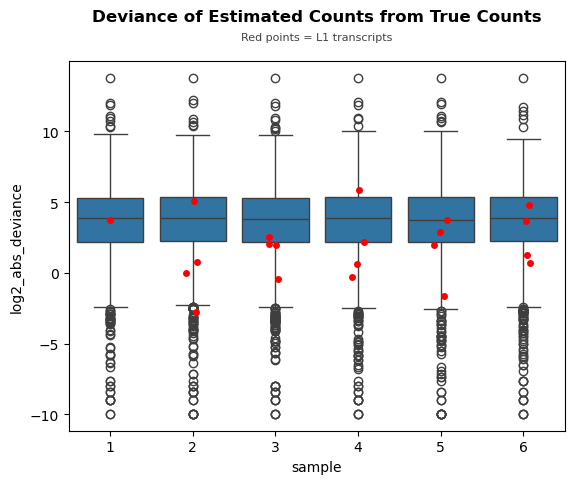

In [37]:
deviance = pd.DataFrame(
    (estimated_counts.to_numpy() - true_counts.to_numpy()),
    index=estimated_counts.index,
    columns=estimated_counts.columns,
)
deviance = deviance.melt(value_name="deviance", var_name="sample", ignore_index=False)
deviance["log2_abs_deviance"] = np.log2(deviance["deviance"].abs())
deviance.reset_index(inplace=True)

ax = plt.gca()
sns.boxplot(
    data=deviance[~deviance.Name.str.contains("chr")],
    x="sample",
    y="log2_abs_deviance",
    ax=ax,
)
sns.stripplot(
    data=deviance[deviance.Name.str.contains("chr")],
    x="sample",
    y="log2_abs_deviance",
    ax=ax,
    color="red",
)
ax.text(
    x=0.5,
    y=1.1,
    s="Deviance of Estimated Counts from True Counts",
    fontsize=12,
    weight="bold",
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)
ax.text(
    x=0.5,
    y=1.05,
    s="Red points = L1 transcripts",
    fontsize=8,
    alpha=0.75,
    ha="center",
    va="bottom",
    transform=ax.transAxes,
)